In [5]:
import os
import json
from joblib import Parallel, delayed

from tqdm import tqdm, trange
from tqdm_joblib import tqdm_joblib

import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../')
from utils import get_stats, read_pickled_object

In [6]:
data_path = '/home/hmbaghda/orcd/pool/metastatic_potential/'
random_state = 42 + 4

n_cores = 64
for v in ["OMP_NUM_THREADS","MKL_NUM_THREADS","OPENBLAS_NUM_THREADS","NUMEXPR_NUM_THREADS"]:
    os.environ[v] = "1" # 1 thread per process; CV handles parallelism

In [7]:
best_pipeline = read_pickled_object(os.path.join(data_path, 'processed', 'best_model.pickle'))

X = pd.read_csv(os.path.join(data_path, 'processed',  'expr.csv'), index_col = 0).values
y = pd.read_csv(os.path.join(data_path, 'processed', 'metastatic_potential.csv'), index_col = 0)['mean'].values.ravel()

# this is only available after running script 01 in notebook C
y_joint = pd.read_csv(os.path.join(data_path, 'processed',  'metastatic_potential_joint.csv'), index_col = 0)
y_proteomics = pd.read_csv(os.path.join(data_path, 'processed',  'metastatic_potential_protein.csv'), index_col = 0)


When iterating through sample sizes, we will keep the test dataset size the same (maximum amount -- 20% of the full dataset). This is to ensure metric stability. 

We also subset N times per sample size to ensure stability.

In [8]:
def run_subset(i, n_samples, X_train_full, y_train_full, X_test, y_test, train_samples_per_fold, seed):
    rng = np.random.default_rng(seed)
    subset_idx = rng.choice(train_samples_per_fold, n_samples, replace=False)
    X_train = X_train_full[subset_idx]
    y_train = y_train_full[subset_idx]
    train_corr, test_corr, train_mse, test_mse = get_stats(best_pipeline, y_train, y_test, X_train, X_test)
    return i, subset_idx, train_corr, test_corr, train_mse, test_mse


def eval_subset(
    i, subset_idx, X_train_full, y_train_full, X_test, y_test, best_pipeline
):
    X_train = X_train_full[subset_idx]
    y_train = y_train_full[subset_idx]
    train_corr, test_corr, train_mse, test_mse = get_stats(
        best_pipeline, y_train, y_test, X_train, X_test
    )
    return i, train_corr, test_corr, train_mse, test_mse


In [19]:
# set up manual fold params
n_splits = 10

fold_size = X.shape[0] // n_splits
train_samples_per_fold = int(np.round(X.shape[0] * ((100 - n_splits)/100)))

# prepare sample sizes
sample_sizes = np.arange(0.1,1.1, 0.1)

n_samples_iter = [int(np.round(train_samples_per_fold*sample_size)) for sample_size in sample_sizes]
if y_joint.shape[0] not in n_samples_iter:
    n_samples_iter.append(y_joint.shape[0]) # ensure the actualy join omics sample size is included
    n_samples_iter = sorted(n_samples_iter)
    
if y_proteomics.shape[0] not in n_samples_iter:
    n_samples_iter.append(y_proteomics.shape[0]) # ensure the actualy join omics sample size is included
    n_samples_iter = sorted(n_samples_iter)

# subsets per sample size
n_subsets = 100

In [21]:
res = pd.DataFrame(columns = ['fold', 'train_sample_size', 
                             'train_corr', 'test_corr', 'train_mse', 'test_mse'])
splits = {}


np.random.seed(random_state)
for k in range(n_splits):
    print(k)
    # manually get splits in order to ensure the are the same size across all folds
    shuffled_index = np.random.permutation(np.arange(X.shape[0]))
    train_idx = shuffled_index[:train_samples_per_fold]
    test_idx = shuffled_index[train_samples_per_fold:]
    
    X_train_full, X_test = X[train_idx], X[test_idx]
    y_train_full, y_test = y[train_idx], y[test_idx]
    
    splits[k] = {'test_idx': test_idx.tolist()}
    
    for n_samples in n_samples_iter:
        splits[k]['train_' + str(n_samples)] = {}
        if n_samples < train_samples_per_fold:
            with tqdm_joblib(desc=f"Fold {k}, n={n_samples}", total=n_subsets):
                subset_results_ = Parallel(n_jobs=n_cores)(
                    delayed(run_subset)(
                        i, n_samples,
                        X_train_full, y_train_full,
                        X_test, y_test,
                        train_samples_per_fold, 
                        seed = 1000*k + 10*n_samples + i
                    )
                    for i in range(n_subsets)
                )
            for i, subset_idx, train_corr, test_corr, train_mse, test_mse in subset_results_:
                res.loc[res.shape[0],:] = [k, n_samples, train_corr, test_corr, train_mse, test_mse]
                splits[k]['train_' + str(n_samples)]['iter_' + str(i)] = subset_idx.tolist()
        else:
            train_corr, test_corr, train_mse, test_mse = get_stats(best_pipeline, y_train_full, y_test, X_train_full, X_test)
            res.loc[res.shape[0],:] = [k, n_samples, train_corr, test_corr, train_mse, test_mse]
            splits[k]['train_' + str(n_samples)]['full'] = train_idx.tolist()
            
    res.to_csv(os.path.join(data_path, 'processed', 'power_analysis_transcriptomics_linear_svr.csv'))
            
with open(os.path.join(data_path, 'interim', 'transcriptomics_power_analysis_folds_all.json'), "w") as json_file:
    json.dump(splits, json_file, indent=4) 
    
for k, inner_dict in splits.items():
    inner_dict_ = {}
    for k_, v in inner_dict.items():
        bool_a = k_ == 'test_idx'
        bool_b = k_.split('_')[1].isdigit() and int(k_.split('_')[1]) not in [y_joint.shape[0], y_proteomics.shape[0]]
        if bool_a or bool_b:
            inner_dict_[k_] = v
    splits[k] = inner_dict_
    
with open(os.path.join(data_path, 'interim', 'transcriptomics_power_analysis_folds.json'), "w") as json_file:
    json.dump(splits, json_file, indent=4)   

Add top-performing non-linear models to power analysis:

In [9]:
with open(os.path.join(data_path, 'interim', 'transcriptomics_power_analysis_folds.json'), "r") as json_file:
    splits = json.load(json_file)
splits = {int(k): v for k,v in splits.items()}
    
    
best_pipelines = {
    'svr_rbf': read_pickled_object(os.path.join(data_path, 'processed', 
                                 'best_model_svr_rbf_transcriptomics.pickle')), 
    'svr_poly': read_pickled_object(os.path.join(data_path, 'processed', 
                                 'best_model_svr_poly_transcriptomics.pickle'))
}    

In [6]:
if os.path.isfile(os.path.join(data_path, 'processed', 'power_analysis_transcriptomics.csv')):
    res = pd.read_csv(os.path.join(data_path, 'processed', 'power_analysis_transcriptomics.csv'), 
                     index_col = 0)
else:
    res = pd.read_csv(os.path.join(data_path, 'processed', 'power_analysis_transcriptomics_linear_svr.csv'), 
                     index_col = 0)
    res['model'] = 'svr_linear'
    res = res[['model', 'fold', 'train_sample_size', 
                                 'train_corr', 'test_corr', 'train_mse', 'test_mse']]

for model_name, best_pipeline in best_pipelines.items():
    for k in range(n_splits):
        if res[(res.model == model_name) & (res.fold == k)].shape[0] == 0:
            print('Model: ' + model_name + ', fold: ' + str(k))
            train_idx = splits[k]['train_433']['full']
            test_idx = splits[k]['test_idx']

            X_train_full, X_test = X[train_idx], X[test_idx]
            y_train_full, y_test = y[train_idx], y[test_idx]

            for (j, n_samples) in enumerate(n_samples_iter):
                bool_a = n_samples not in [y_joint.shape[0], y_proteomics.shape[0]] 
#                 bool_b = (model_name == 'svr_linear')
                if n_samples < train_samples_per_fold:
                    if bool_a:# or bool_b:
                        with tqdm_joblib(
                            desc=f"Subsets (n={n_samples}, fold={k})",
                            total=n_subsets,
                            leave=False
                        ):
                            subset_results_ = Parallel(n_jobs=n_cores)(
                                delayed(eval_subset)(
                                    i,
                                    splits[k][f"train_{n_samples}"][f"iter_{i}"],
                                    X_train_full,
                                    y_train_full,
                                    X_test,
                                    y_test,
                                    best_pipeline
                                )
                                for i in range(n_subsets)
                            )
                        for i, trc, tec, trm, tem in subset_results_:
                            res.loc[res.shape[0], :] = [
                                model_name, k, n_samples, trc, tec, trm, tem
                            ] 
                else:
                    train_corr, test_corr, train_mse, test_mse = get_stats(best_pipeline, y_train_full, y_test, X_train_full, X_test)
                    res.loc[res.shape[0],:] = [model_name, k, n_samples, train_corr, test_corr, train_mse, test_mse]

            res.to_csv(os.path.join(data_path, 'processed', 'power_analysis_transcriptomics.csv'))

# Analyze

In [15]:
res = pd.read_csv(os.path.join(data_path, 'processed', 'power_analysis_transcriptomics.csv'), index_col = 0)

# just visualize the equal interval samples
res = res[~res.train_sample_size.isin([y_joint.shape[0], y_proteomics.shape[0]])]
res.to_csv('power_analysis_for_shashwat.csv')

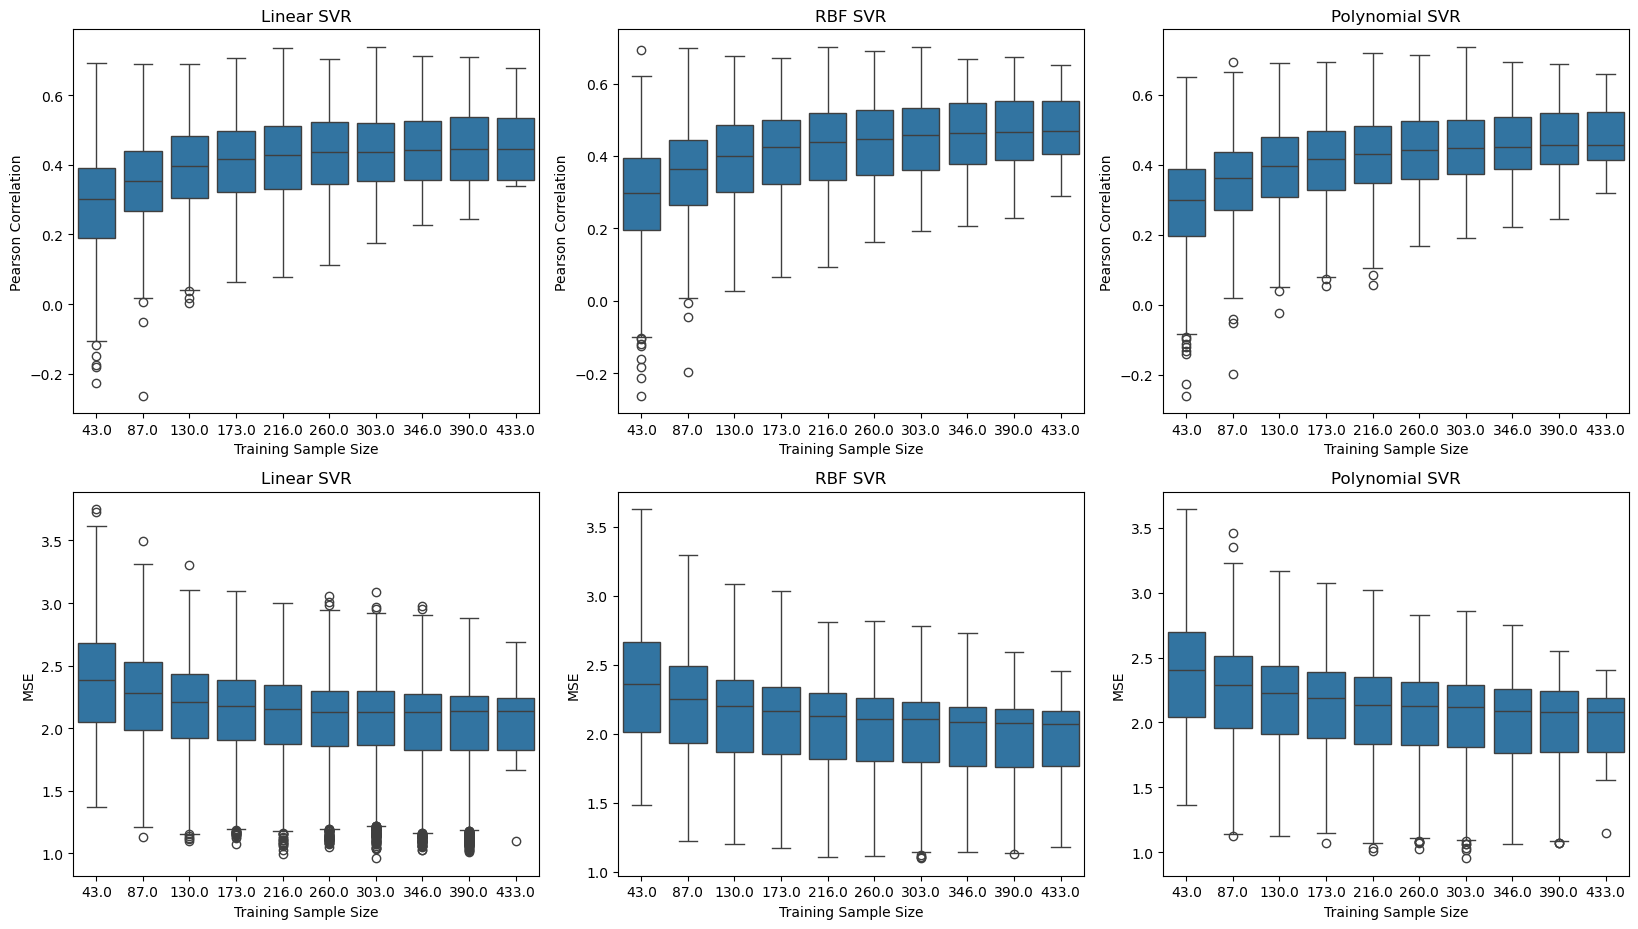

In [16]:
metric_types = ['corr', 'mse']
mmap = dict(zip(metric_types, ['Pearson Correlation', 'MSE']))
title_map = {'svr_linear': 'Linear SVR', 
            'svr_rbf': 'RBF SVR', 
            'svr_poly': 'Polynomial SVR'}


ncols = res.model.nunique()
nrows = len(metric_types)
fig, axes = plt.subplots(ncols = ncols, nrows = nrows, figsize = (5.5*ncols, 4.7*nrows))

for (j, model_name) in enumerate(res.model.unique()):
    viz_df = res[res.model == model_name]
    
    for (i, metric_type) in enumerate(metric_types):
        sns.boxplot(data = viz_df, x = 'train_sample_size', y = 'test_' + metric_type, 
                   ax = axes[i,j])
        axes[i,j].set_title(title_map[model_name])
        axes[i,j].set_ylabel(mmap[metric_type])
        axes[i,j].set_xlabel('Training Sample Size')
        
        
        
fig.tight_layout()
plt.savefig(os.path.join(data_path, 'figures', 'power_analysis_barplots.png'), 
            dpi=300, 
            bbox_inches="tight")